# Inference: Delayed Rejection Adaptive Covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using [DRAM ACMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/dram_ac_mcmc.html) as described in [1]. This method allows users to have a number of proposal kernels. Typically, the first proposal kernel is wider (and hence can explore more aggressively); if this proposal is rejected, then subsequent kernels are more narrower to encourage, at least, some movement of the chains.


[1] "DRAM: Efficient adaptive MCMC".
    H Haario, M Laine, A Mira, E Saksman, (2006) Statistical Computing
    https://doi.org/10.1007/s11222-006-9438-0

In our first use of the model, we try using 3 different proposal kernels that scale the proposal distributions to be of three different orders of magnitude.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot
import pints.toy

Running...


/home/michael/dev/pints/pints/_mcmc/_dram_ac.py:131: RuntimeWarning: divide by zero encountered in log
  i, Y_rev[0:(i + 2)], log_Y_rev[0:(i + 2)]))) -
/home/michael/dev/pints/pints/_mcmc/_dram_ac.py:133: RuntimeWarning: divide by zero encountered in log
  i, Y[0:(i + 2)], log_Y[0:(i + 2)])))
/home/michael/dev/pints/pints/_mcmc/_dram_ac.py:133: RuntimeWarning: invalid value encountered in double_scalars
  i, Y[0:(i + 2)], log_Y[0:(i + 2)])))
/home/michael/dev/pints/pints/_mcmc/_dram_ac.py:113: RuntimeWarning: invalid value encountered in double_scalars
  alpha_log = log_Y[n + 1] - log_Y[0]


Done!


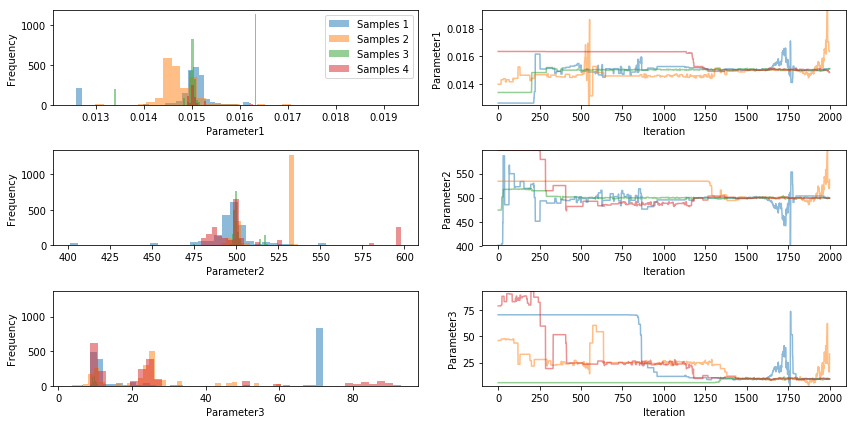

In [2]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*10]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 4 mcmc chains
xs = log_prior.sample(4)

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.DramACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Try 3 proposal kernels
for i in range(len(xs)):
    mcmc.samplers()[i].set_n_kernels(3)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Show graphs
plt.show()

We now look at the MCMC sample quantiles and sampling diagnostics.

In [3]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  -----  --------------
r        0.02    0.00    0.01    0.01    0.02    0.02    0.02     1.47    38.59  0.98
k        507.83  24.53   481.25  498.14  499.99  517.15  598.20   1.20    78.72  1.99
sigma    23.98   22.61   6.07    9.43    12.02   25.23   82.11    1.88    16.92  0.43


With three kernels, things look a little unstable in the sampling, so let's try just two instead.

Running...
Done!


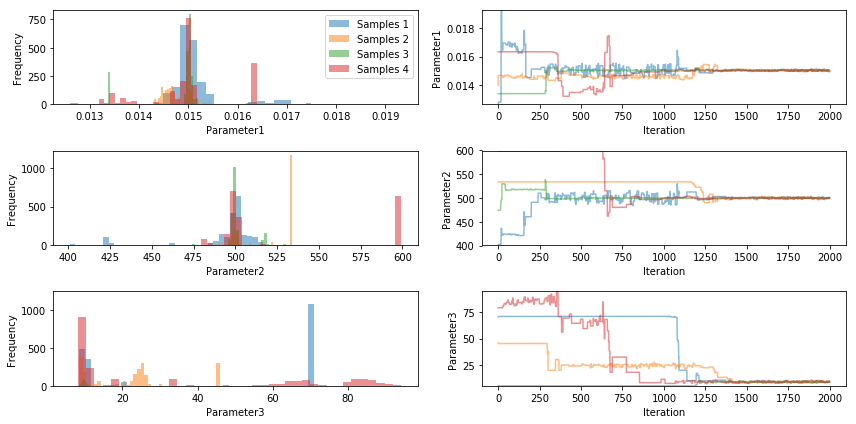

In [4]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.DramACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Try 3 proposal kernels
for i in range(len(xs)):
    mcmc.samplers()[i].set_n_kernels(2)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Show graphs
plt.show()

The above looks much better and we typically get a higher ESS than for the three kernel case.

In [5]:
results = pints.MCMCSummary(
    chains=chains, 
    time=mcmc.time(), 
    parameter_names=['r', 'k', 'sigma']
)
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  -----  --------------
r        0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.08    51.72  3.35
k        511.43  31.31   461.74  498.78  500.40  517.70  599.05   1.48    29.29  1.90
sigma    26.70   25.97   6.07    9.19    10.44   45.41   83.55    2.19    13.58  0.88
